In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_fBiPotDDims_NonSep.recursive_Markovian_PostMeanScore_fBiPot8DimsNS_T256_H05_tl_110data_StbleTgt_FULLDATA import get_config

In [2]:
config = get_config()
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 10240
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [3]:
import pandas as pd
def get_drift_files(config, root_dir ):
    ts_type = f"{config.ndims}DDimsNS"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/8DDimsNS/"
    true_files = []
    local_files = []
    mses = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
            elif "bwidx" in file and "MSEs" not in file:
                mses_full = pd.read_parquet(root_nadaraya_dir+file)
                mses.append(mses_full)
    mses = pd.concat(mses).sort_values("bw", axis=0).dropna()
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[4][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws, mses

In [4]:
config = get_config()
true_files, local_files, bws, mses = get_drift_files(config=config, root_dir=root_dir)

In [5]:
print(mses)

          bw          mse
0   0.000282  2134.119075
1   0.000372  2134.124802
2   0.000491  2134.078487
3   0.000649  2133.986784
4   0.000857  2133.836372
5   0.001131  2133.388490
6   0.001493  2132.454389
7   0.001972  2131.164465
8   0.002603  2129.176504
9   0.003437  2125.525099
10  0.004538  2118.764753
11  0.005992  2106.212436
12  0.007912  2083.223457
13  0.010446  2045.099591
14  0.013793  1980.675404
15  0.018211  1869.384127
16  0.024046  1680.924949
17  0.031749  1379.369905
18  0.041919   951.532933
19  0.055348   490.602128
20  0.073079   188.277698
21  0.096490    69.963120
22  0.127401    33.052857
23  0.168214    18.642285
24  0.222102    11.112197
25  0.293252     6.869750
26  0.387196     4.434490
27  0.511235     2.951329
28  0.675010     2.109817
29  0.891251     1.667856


Text(0.5, 1.0, 'Minimum MSE is (1.6678560857703046, 29)')

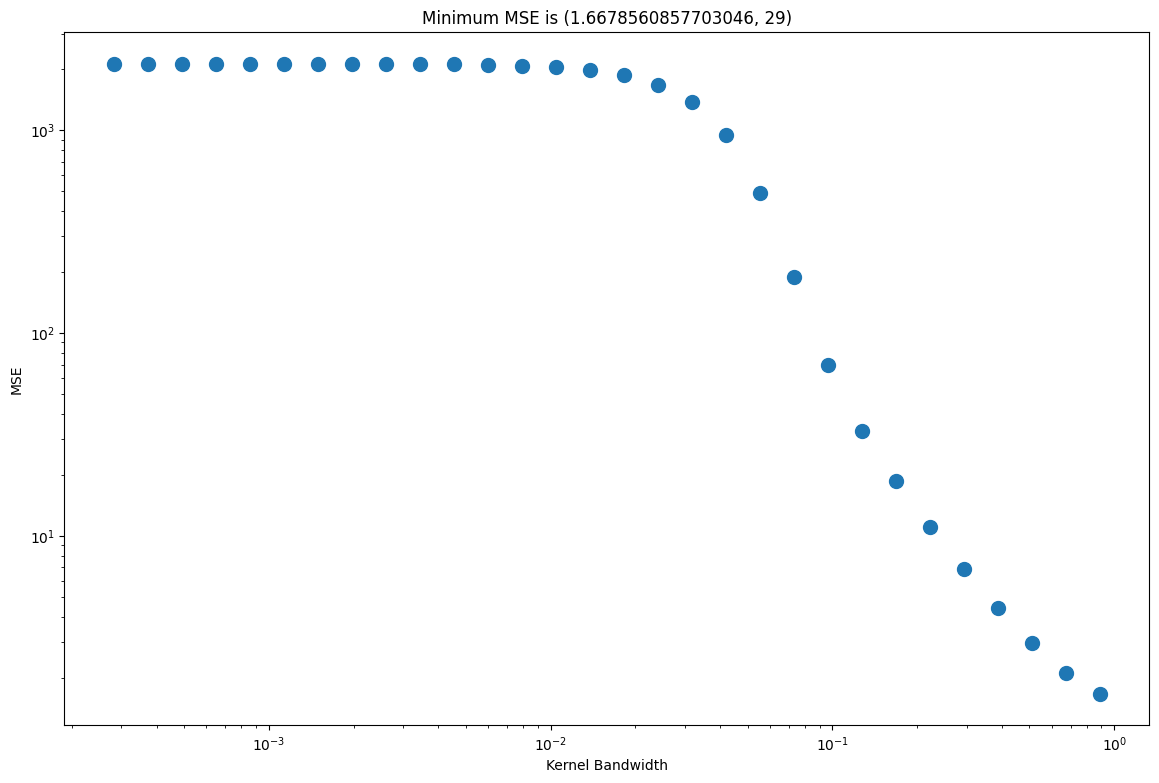

In [7]:
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("MSE")
ax.set_xlabel("Kernel Bandwidth")
ax.set_title(f"Minimum MSE is {mses.iloc[np.argmin(mses.mse), 1], np.argmin(mses.mse)}")